https://www.kaggle.com/pavlofesenko/selling-life-insurance-to-titanic-passengers?scriptVersionId=9284633

In [1]:
# Silencing warnings from scikit-learn
import warnings
warnings.filterwarnings("ignore")

# Importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection, linear_model, metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Import Titanic data

### Training data that we use for training our model
For this data we know if passengers survived or not. 

In [2]:
data = pd.read_csv("all_data/train.csv")

# Understand the data

In [3]:
data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
"""
basic information about the occurence of data 
more descriptive information can be found here https://www.kaggle.com/c/titanic/data
"""
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Almost all columns have data, just column "Cabin" does not contain that much --> candidate to remove 

In [5]:
# What rough procentage of passengers survived? Since it is 0 (died) and 1 (survived) the average is the survival rate. 
data['Survived'].mean()

0.3838383838383838

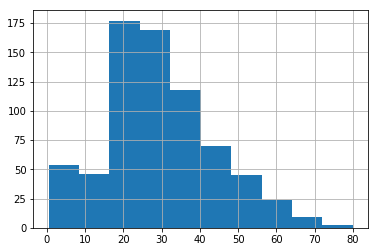

In [6]:
# Age distribution on board
data['Age'].hist()

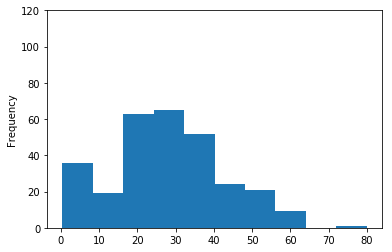

In [7]:
data['Age'].where(data['Survived']==1).plot.hist(ylim=(0,120))

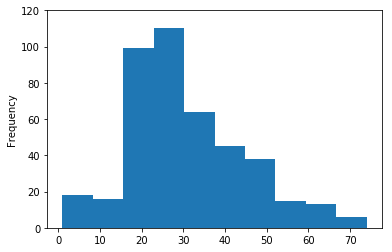

In [8]:
data['Age'].where(data['Survived']==0).plot.hist(ylim=(0,120))

Looks like more persons under 10 surviced, but not so many between 18 and 30. So age could be a valuable feature to take into our model.

In [9]:
# Gender distribution on board
print("Male passengers: %s" %data[data["Sex"]=='male'].count()["Sex"])
print("Female passengers: %s" %data[data["Sex"]=='female'].count()["Sex"])

Male passengers: 577
Female passengers: 314


That is interesting. Woman and children were treated differently during emergency disembarktion. So we could expect differnt survival rates.

In [10]:
print("Survival rate male passengers: %s" % data[data["Sex"]=='male']['Survived'].mean())
print("Survival rate female passengers: %s" % data[data["Sex"]=='female']['Survived'].mean())

Survival rate male passengers: 0.18890814558058924
Survival rate female passengers: 0.7420382165605095


This is definitely an interesting feature for our model. 

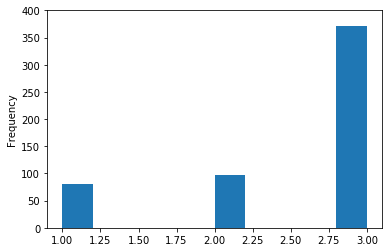

In [11]:
data['Pclass'].where(data['Survived']==0).plot.hist(ylim=(0,400))

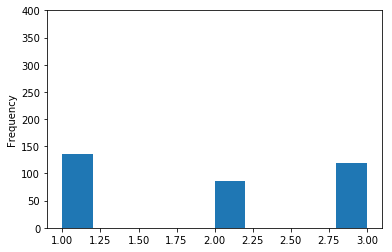

In [12]:
data['Pclass'].where(data['Survived']==1).plot.hist(ylim=(0,400))

For the survivers it looks quite even between the classes, but for the persons that died there is definitely a majority of 3rd class.

# Feature selection

Next we select features that might be interesting. --> This process usually takes long with real data. 
An intuitive selection after looking at the data:
* Pclass
* Sex
* Age
* Fare

We keep PassengerId for now, but we will separate it later. 


In [13]:
# Throw all columns that are not interesitng
X = data.drop(['SibSp', 'Parch', 'Embarked', 'Name', 'Ticket', 'Cabin'], axis=1)
X.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare
0,1,0,3,male,22.0,7.2500
1,2,1,1,female,38.0,71.2833
2,3,1,3,female,26.0,7.9250
3,4,1,1,female,35.0,53.1000
4,5,0,3,male,35.0,8.0500


### Cleaning up and transform categorical data

In [14]:
def preprocess(df):
    
    X = df.copy()
    X = X.dropna(axis=0)
    
    # Separate PassengerId that we need later for output format, but is not part of the model
    passengerId = X['PassengerId']
    X = X.drop(['PassengerId'],axis=1)

    # Separating the feature matrix according to numeric and categorical features
    num_feat = X.select_dtypes('number').columns.values
    cat_feat = X.select_dtypes('object').columns.values
    X_num = X[num_feat]
    X_cat = X[cat_feat]
    
    # Scaling the numeric features using standardization
    # X_num = (X_num - X_num.mean()) / X_num.std()
    # X_num = X_num.fillna(X_num.mean())
    
    # Encoding the categorical features using one-hot encoding
    X_cat = pd.get_dummies(X_cat)
    
    X = pd.concat([X_num, X_cat], axis=1)
    return X, passengerId

In [15]:
X['Pclass'] = X['Pclass'].astype(str)
X, passengerId = preprocess(X)

In [16]:
X.head()

,Survived,Age,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
0,0,22.0,7.2500,0,0,1,0,1
1,1,38.0,71.2833,1,0,0,1,0
2,1,26.0,7.9250,0,0,1,1,0
3,1,35.0,53.1000,1,0,0,1,0
4,0,35.0,8.0500,0,0,1,0,1


In [17]:
y = X['Survived']
X = X.drop(['Survived'], axis=1)

We select the target value that we want to learn to predict. In this case it's "Survived".

# Train the model

In [18]:
# Splitting the final dataset into training and testing datasets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=0)

In [19]:
X_train.count()

Age           535
Fare          535
Pclass_1      535
Pclass_2      535
Pclass_3      535
Sex_female    535
Sex_male      535
dtype: int64

In [20]:
X_test.count()

Age           179
Fare          179
Pclass_1      179
Pclass_2      179
Pclass_3      179
Sex_female    179
Sex_male      179
dtype: int64

In [21]:
# Define a decision tree https://scikit-learn.org/stable/modules/tree.html
model = DecisionTreeClassifier(min_samples_split=5, max_leaf_nodes=7, random_state=0) # Random state is fixed for reproducibility

In [22]:
# Fit the model with training data 
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [31]:
from sklearn.tree import export_graphviz

export_graphviz(model, out_file='decision_tree_titanic.dot')

# need to run "dot -Tpng decision_tree_titanic.dot -o decision_tree_titanic.png" to convert dot to png

![title](decision_tree_titanic.png)

In [32]:
for i in range(7):
    print("X%s : %s" % (i, X_test.columns[i]))

X0 : Age
X1 : Fare
X2 : Pclass_1
X3 : Pclass_2
X4 : Pclass_3
X5 : Sex_female
X6 : Sex_male


The dark blue boxes indicate passengers who are likely to survive, and the dark orange boxes represent passengers who most certainly die.

The first split criteria is gender male X6, which we expected from the survival rate. 
The woman branch is on the left and the man on the right.
Next criteria for women is class X4. If you are not in 3rd class you most likely survive. 

Man who are young and not in 3rd class have a good chance. For the rest it looks quite dark.

X <>= 0.X: Splitting criteria

gini: Quality measure of the slit

samples: number of datapoints that fall in this bucket

value: Range of value that 


In [33]:
# Predict our test data
y_pred = model.predict(X_test)

In [34]:
# Evaluate the accuracy of the model 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
metrics.accuracy_score(y_test, y_pred)

0.7821229050279329

In [35]:
y_pred_train = model.predict(X_train)
metrics.accuracy_score(y_pred_train, y_train)

0.8299065420560747

# THAT'S IT!! 

# Predict for real test data
Kaggle wants the data output format in the following way:

PassengerId,Survived
1,0
2,1
3,1
4,0
...

In [36]:
test_data = pd.read_csv("all_data/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [37]:
X_test_pred = test_data.drop(['SibSp', 'Parch', 'Embarked', 'Name', 'Ticket', 'Cabin'], axis=1)

In [38]:
X_test_pred['Pclass'] = X_test_pred['Pclass'].astype(str)
X_test_pred, passengerId_test_pred = preprocess(X_test_pred)

In [39]:
results = {'PassengerId' : passengerId_test_pred , 
           'Survived' : model.predict(X_test_pred)}

In [40]:
result_df = pd.DataFrame(results)
result_df.head(30)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,0
7,899,0
8,900,0
9,901,0


In [41]:
result_df.to_csv('results_titanic_lunch_and_learn_20190130.csv', index=False)

In [23]:
# you need to install pydotplus for this visualization of the decision tree

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'